<h1> Fine-Tune BERT for Text Classification with TensorFlow</h1>

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1mBqrfxng42SgSXvK62V1C67Or_vgrsVm' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

We will be using GPU accelerated Kernel for this tutorial as we would require a GPU to fine-tune BERT.

## Prerequisites:
- Willingness to learn: Growth Mindset is all you need 
- Some basic idea about Tensorflow/Keras 
- Some Python to follow along with the code 

## Initial Set Up

### Install TensorFlow and TensorFlow Model Garden

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

Cloning the Github Repo for tensorflow models 
-  –depth 1, during cloning, Git will only get the latest copy of the relevant files. It can save you a lot of space and time.

- -b lets us clone a specific branch only.

**Please match it with your tensorflow 2.x version.**

In [ ]:
!git clone --depth 1 -b v2.4.0 https://github.com/tensorflow/models.git

In [ ]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards, also ignore any ERRORS popping up at this step

**Note**: After installing the required Python packages, you'll need to restart the Colab Runtime Engine 
(Run ---> Restart and clear all cell outputs...)

**NOTE: ANYTHING BEFORE THIS CELL SHOULD ONLY BE RUN ONCE, ONLY DURING THE INITIAL SETUP**

## Some Initial Imports and Checks

A Healthy practice for any ML practioner is to do a clean experiment tracking such that reasults are reproducable and trackable. For this kernel we will be looking into [Weights and Biases](https://wandb.ai/site) for experiment tracking.

Here are Four main things that W&B offers:
- Experiment Tracking: Tracking ML Experiments and logging various parameters and metrics on a clean dashboard.
- Sweeps: Hyper-parameter tuning. You can run multiple experiments with different hyper-parameters and track them.
- Artifacts: Storing Datasets, models and other files for version tracking.
- Reports: we can create reports on experiments and project levels.


We will be looking into, **Experiment Trancking** and **Artifacts**

In [1]:
!pip install --upgrade -q wandb

#### Logging into wandb.
First things first, we need to create a free account on [W&B](https://wandb.ai/site)

Then let us access our [authorization API key](https://wandb.ai/authorize) and add it to kaggle's secret key for hassle free authentication.

More details about Kaggle's Secret key feature on ---> https://www.kaggle.com/product-feedback/114053

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb-api")


In [3]:
import wandb
from wandb.keras import WandbCallback
wandb.login(key=wandb_api)


wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [5]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.4.1
Eager mode:  True
Hub version:  0.12.0
GPU is available


## Lets Get the Dataset

- The data we will use is the dataset provided on the [Quora Insincere Questions Classification competition on Kaggle](https://www.kaggle.com/c/quora-insincere-questions-classification/data). 

- Please feel free to download the train set from kaggle or use the link below to download the train.csv from that competition [https://archive.org/download/quora_dataset_train.csv/quora_dataset_train.csv.zip](https://archive.org/download/quora_dataset_train.csv/quora_dataset_train.csv.zip). 

- Let us decompress and read the data into a pandas DataFrame.

In [6]:
# TO LOAD DATA FROM ARCHIVE LINK
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split

# df = pd.read_csv('https://archive.org/download/quora_dataset_train.csv/quora_dataset_train.csv.zip', 
#                  compression='zip',
#                  low_memory=False)
# print(df.shape)

In [7]:
# TO LOAD DATA FROM KAGGLE
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
print(df.shape)

(1306122, 3)


In [8]:
df.head(10)
# label 0 == non toxic
# label 1 == toxic 

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


### Get to Know your data: Some Basic EDA

0    1225312
1      80810
Name: target, dtype: int64


Text(0.5, 1.0, 'Distribution of Labels')

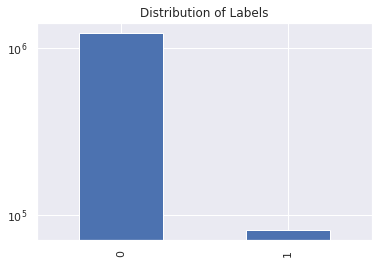

In [9]:
print(df['target'].value_counts())
df['target'].value_counts().plot.bar()
plt.yscale('log');
plt.title('Distribution of Labels')

In [10]:
print('Average word length of questions in dataset is {0:.0f}.'.format(np.mean(df['question_text'].apply(lambda x: len(x.split())))))
print('Max word length of questions in dataset is {0:.0f}.'.format(np.max(df['question_text'].apply(lambda x: len(x.split())))))
print('Average character length of questions in dataset is {0:.0f}.'.format(np.mean(df['question_text'].apply(lambda x: len(x)))))

Average word length of questions in dataset is 13.
Max word length of questions in dataset is 134.
Average character length of questions in dataset is 71.


In [11]:
# Since the dataset is very imbalanced we will keep the same distribution in both train and test set by stratifying it based on the labels
# using small portions of the data as the over all dataset would take ages to train, feel free to include more data by changing train_size 
train_df, remaining = train_test_split(df, random_state=42, train_size=0.1, stratify=df.target.values)
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.01, stratify=remaining.target.values)
print(train_df.shape)
print(valid_df.shape)

(130612, 3)
(11755, 3)


In [12]:
print("FOR TRAIN SET\n")
print('Average word length of questions in train set is {0:.0f}.'.format(np.mean(train_df['question_text'].apply(lambda x: len(x.split())))))
print('Max word length of questions in train set is {0:.0f}.'.format(np.max(train_df['question_text'].apply(lambda x: len(x.split())))))
print('Average character length of questions in train set is {0:.0f}.'.format(np.mean(train_df['question_text'].apply(lambda x: len(x)))))
print('Label Distribution in train set is \n{}.'.format(train_df['target'].value_counts()))
print("\n\nFOR VALIDATION SET\n")
print('Average word length of questions in valid set is {0:.0f}.'.format(np.mean(valid_df['question_text'].apply(lambda x: len(x.split())))))
print('Max word length of questions in valid set is {0:.0f}.'.format(np.max(valid_df['question_text'].apply(lambda x: len(x.split())))))
print('Average character length of questions in valid set is {0:.0f}.'.format(np.mean(valid_df['question_text'].apply(lambda x: len(x)))))
print('Label Distribution in validation set is \n{}.'.format(valid_df['target'].value_counts()))

FOR TRAIN SET

Average word length of questions in train set is 13.
Max word length of questions in train set is 59.
Average character length of questions in train set is 71.
Label Distribution in train set is 
0    122531
1      8081
Name: target, dtype: int64.


FOR VALIDATION SET

Average word length of questions in valid set is 13.
Max word length of questions in valid set is 53.
Average character length of questions in valid set is 70.
Label Distribution in validation set is 
0    11028
1      727
Name: target, dtype: int64.


So it looks like the train and validation set are similar in terms of class imbalance and the various lengths in the question texts.

Text(0.5, 1.0, 'Distribution of question text length in words')

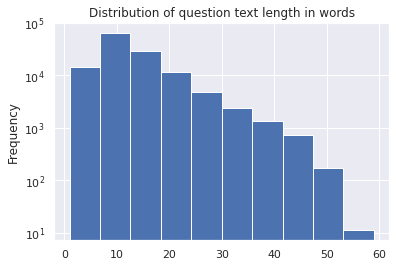

In [13]:
# TRAIN SET 
train_df['question_text'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of question text length in words')

Text(0.5, 1.0, 'Distribution of question text length in words')

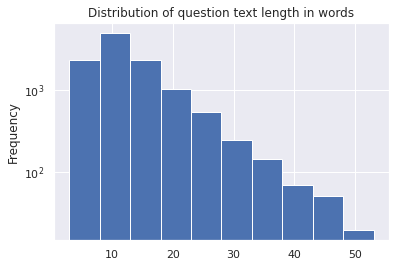

In [14]:
# VALIDATION SET
valid_df['question_text'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of question text length in words')

Text(0.5, 1.0, 'Distribution of question text length in characters')

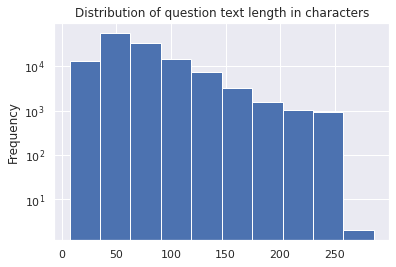

In [15]:
# TRAIN SET
train_df['question_text'].apply(lambda x: len(x)).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of question text length in characters')

Text(0.5, 1.0, 'Distribution of question text length in characters')

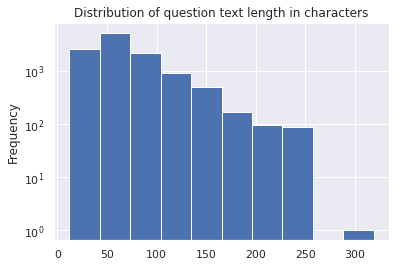

In [16]:
# VALIDATION SET
valid_df['question_text'].apply(lambda x: len(x)).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of question text length in characters')

Even the distribution of question length in words and characters is very similar. It looks like a good train test split so far.

# Taming the Data

In [17]:
# we want the dataset to be created and processed on the cpu 
with tf.device('/cpu:0'):
    train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
    valid_data = tf.data.Dataset.from_tensor_slices((valid_df['question_text'].values, valid_df['target'].values))
    # lets look at 3 samples from train set
    for text,label in train_data.take(3):
        print(text)
        print(label)


tf.Tensor(b'If we trade in hourly timefram how we can predict what happen in 15 minutes timefram?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'Is there any testing or coaching that helps people decide their college major to begin their career?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'What is Norton 360 useful for?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [18]:
print(len(train_data))
print(len(valid_data))

130612
11755


## Lets BERT: Get the Pre-trained BERT Model from TensorFlow Hub

We will be using the uncased BERT present in the tfhub. In order to prepare the text to be given to the BERT layer, we need to first tokenize our words. The tokenizer here is present as a model asset and will do uncasing for us as well.

Setting all parameters in form of a dictionary so any changes if needed can be made here

In [19]:
# Setting some parameters

config = {'label_list' : [0, 1], # Label categories
          'max_seq_length' : 128, # maximum length of (token) input sequences
          'train_batch_size' : 32,
          'learning_rate': 2e-5,
          'epochs':7,
          'optimizer': 'adam',
          'dropout': 0.5,
          'train_samples': len(train_data),
          'valid_samples': len(valid_data),
          'train_split':0.1,
          'valid_split': 0.01
         }

In [20]:
# Get BERT layer and tokenizer:
# All details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2

bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2',
                            trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy() # checks if the bert layer we are using is uncased or not
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

### Checking out some of the training samples and their tokenized ids

In [21]:
input_string = "hello world, it is a wonderful day for learning"
print(tokenizer.wordpiece_tokenizer.tokenize(input_string))
print(tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize(input_string)))

['hello', 'world', '##,', 'it', 'is', 'a', 'wonderful', 'day', 'for', 'learning']
[7592, 2088, 29623, 2009, 2003, 1037, 6919, 2154, 2005, 4083]


## Lets Get That Data Ready: Tokenize and Preprocess Text for BERT

Each line of the dataset is composed of the review text and its label.
Data preprocessing consists of transforming text to BERT input features:
`input_word_ids`, `input_mask`, `segment_ids/input_type_ids`

- **Input Word Ids:** Output of our tokenizer, converting each sentence into a set of token ids.

- **Input Masks:** Since we are padding all the sequences to 128(max sequence length), it is important that we create some sort of mask to make sure those paddings do not interfere with the actual text tokens. Therefore we need a generate input mask blocking the paddings. The mask has 1 for real tokens and 0 for padding tokens. Only real
tokens are attended to.

- **Segment Ids:** For out task of text classification, since there is only one sequence, the segment_ids/input_type_ids is essentially just a vector of 0s. 



Bert was trained on two tasks:
- fill in randomly masked words from a sentence.
- given two sentences,  which sentence came first. 


In [22]:
# This provides a function to convert row to input features and label, 
# this uses the classifier_data_lib which is a class defined in the tensorflow model garden we installed earlier
def create_feature(text, label, label_list=config['label_list'], max_seq_length=config['max_seq_length'], tokenizer=tokenizer):
    """
    converts the datapoint into usable features for BERT using the classifier_data_lib

    Parameters:
    text: Input text string
    label: label associated with the text
    label_list: (list) all possible labels
    max_seq_length: (int) maximum sequence length set for bert
    tokenizer: the tokenizer object instantiated by the files in model assets

    Returns:
    feature.input_ids: The token ids for the input text string
    feature.input_masks: The padding mask generated 
    feature.segment_ids: essentially here a vector of 0s since classification
    feature.label_id: the corresponding label id from lable_list [0, 1] here

    """
    # since we only have 1 sentence for classification purpose, textr_b is None
    example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(), 
                                            text_b = None, 
                                            label = label.numpy())
    # since only 1 example, the index=0
    feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)

    return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

### Wrapping the Python Function into a TensorFlow op for Eager Execution

In [23]:
def create_feature_map(text, label):
    """
    A tensorflow function wrapper to apply the transformation on the dataset.
    Parameters:
    Text: the input text string.
    label: the classification ground truth label associated with the input string

    Returns:
    A tuple of a dictionary and a corresponding label_id with it. The dictionary 
    contains the input_word_ids, input_mask, input_type_ids  
    """
    input_ids, input_mask, segment_ids, label_id = tf.py_function(create_feature, inp=[text, label], 
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
    max_seq_length = config['max_seq_length']

    # py_func doesn't set the shape of the returned tensors.
    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    label_id.set_shape([])

    x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
    return (x, label_id)

    # the final datapoint passed to the model is of the format a dictionary as x and labels.
    # the dictionary have keys which should obv match

## Let the Data Flow: Creating the final input pipeline using `tf.data`

In [24]:
# Now we will simply apply the transformation to our train and test datasets
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(create_feature_map,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)

                          .shuffle(1000)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(create_feature_map, 
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE)) 

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [25]:
# train data spec, we can finally see the input datapoint is now converted to the BERT specific input tensor
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [26]:
# valid data spec
valid_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

# Lets Model Our Way to Glory!!!

## Create The Model

There are two outputs from the BERT Layer: 
- A pooled_output of shape [batch_size, 768] with representations for the entire input sequences.  
- A sequence_output of shape [batch_size, max_seq_length, 768] with representations for each input token (in context).

For the classification task, we are only concerned with the pooled_output.

In [27]:
# Building the model, input ---> BERT Layer ---> Classification Head
def create_model():
    
    input_word_ids = tf.keras.layers.Input(shape=(config['max_seq_length'],), dtype=tf.int32,
                                       name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(config['max_seq_length'],), dtype=tf.int32,
                                   name="input_mask")
    input_type_ids = tf.keras.layers.Input(shape=(config['max_seq_length'],), dtype=tf.int32,
                                    name="input_type_ids")


    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
    # for classification we only care about the pooled-output
    # at this point we can play around with the classification head based on the downstream tasks and its complexity

    drop = tf.keras.layers.Dropout(config['dropout'])(pooled_output)
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(drop)

    # inputs coming from the function
    model = tf.keras.Model(
      inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids}, 
      outputs=output)

    return model
  

## Let Us Train !

In [28]:
# Calling the create model function to get the keras based functional model
model = create_model()

In [29]:
# using adam with a lr of 2*(10^-5), loss as binary cross entropy as only 2 classes and similarly binary accuracy
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.PrecisionAtRecall(0.5),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

One drawback of the tf hub is that we import the entire module as a layer in keras as a result of which we dont see the parameters and layers in the model summary.

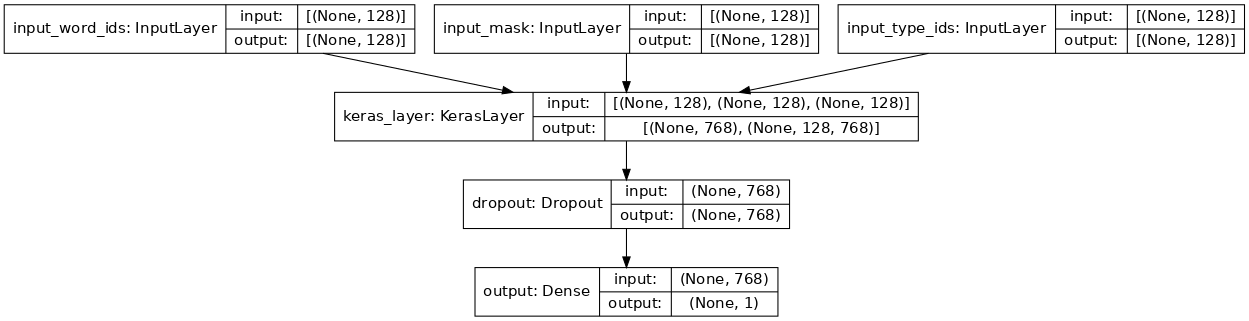

In [30]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76, )

The official tfhub page states that
"All parameters in the module are trainable, and fine-tuning all parameters is the recommended practice." Therefore we will go ahead and train teh entire model without freezing anything

#### W&B Experiment Tracking
In order to start the expirment tracking, we will be creating 'runs' on W&B, 

`wandb.init()`: It initializes the run with basic project information
parameters: 
- project: The project name, this will create a new project tab where all the experiments for this project will be tracked
- config: A dictionary of all parameters and hyper-parameters we wish to track
- group: optional, but would help us to group by different parameters later on
- job_type: to describe the job type, it would help in grouping different experiments later. eg "train", "evaluate" etc

In [31]:
# Update CONFIG dict with the name of the model.
config['model_name'] = 'BERT_EN_UNCASED'
print('Training configuration: ', config)

# Initialize W&B run
run = wandb.init(project='Finetune-BERT-Text-Classification', 
                 config=config,
                 group='BERT_EN_UNCASED', 
                 job_type='train')

wandb: Currently logged in as: akshayuppal12 (use `wandb login --relogin` to force relogin)


Training configuration:  {'label_list': [0, 1], 'max_seq_length': 128, 'train_batch_size': 32, 'learning_rate': 2e-05, 'epochs': 7, 'optimizer': 'adam', 'dropout': 0.5, 'train_samples': 130612, 'valid_samples': 11755, 'train_split': 0.1, 'valid_split': 0.01, 'model_name': 'BERT_EN_UNCASED'}


In order to Log all the different metrics we will use a simple callback provided by W&B

`WandCallback()` : https://docs.wandb.ai/guides/integrations/keras

Yes, Its as simple as adding a callback :D

In [32]:
# Train model
# setting low epochs as It starts to overfit with this limited data, please feel free to change
epochs = config['epochs']
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [WandbCallback()])
run.finish()

Epoch 1/7
4081/4081 [==============================] - 2018s 491ms/step - loss: 0.1483 - binary_accuracy: 0.9441 - precision_at_recall: 0.5579 - precision: 0.5912 - recall: 0.4287 - val_loss: 0.0951 - val_binary_accuracy: 0.9608 - val_precision_at_recall: 0.7821 - val_precision: 0.7524 - val_recall: 0.5475
Epoch 2/7
4081/4081 [==============================] - 2004s 491ms/step - loss: 0.0877 - binary_accuracy: 0.9647 - precision_at_recall: 0.8110 - precision: 0.7386 - recall: 0.6815 - val_loss: 0.1100 - val_binary_accuracy: 0.9580 - val_precision_at_recall: 0.7360 - val_precision: 0.6477 - val_recall: 0.7056
Epoch 3/7
4081/4081 [==============================] - 2003s 490ms/step - loss: 0.0525 - binary_accuracy: 0.9804 - precision_at_recall: 0.9277 - precision: 0.8428 - recall: 0.8489 - val_loss: 0.1622 - val_binary_accuracy: 0.9596 - val_precision_at_recall: 0.7700 - val_precision: 0.7351 - val_recall: 0.5420
Epoch 4/7
4081/4081 [==============================] - 2003s 490ms/step - lo

epoch,6
loss,0.00921
binary_accuracy,0.99683
precision_at_recall,0.9978
precision,0.97344
recall,0.97537
val_loss,0.264
val_binary_accuracy,0.95794
val_precision_at_recall,0.73506
val_precision,0.68006
val_recall,0.60523


epoch,▁▂▃▅▆▇█
loss,█▅▃▂▁▁▁
binary_accuracy,▁▃▆▇███
precision_at_recall,▁▅▇████
precision,▁▃▆▇███
recall,▁▄▇▇███
val_loss,▁▂▄▄▇▇█
val_binary_accuracy,█▂▅▁▄▃▂
val_precision_at_recall,█▃▇▁▆▂▃
val_precision,█▁▇▃▅▂▃
val_recall,▁█▁▃▂▅▄


### Lets Evaluate

Let us do an evaluation on the validation set and log the scores using weights and biases.

**wandb.log()**: Log a dict of scalars (metrics like accuracy and loss) and any other type of wandb object.
Here we will pass the evaluation dictionary as it is and log it.

In [33]:
# Initialize a new run for the evaluation-job
run = wandb.init(project='Finetune-BERT-Text-Classification', 
                 config=config,
                 group='BERT_EN_UNCASED', 
                 job_type='evaluate')



# Model Evaluation on validation set
evaluation_results = model.evaluate(valid_data,return_dict=True)

# Log scores using wandb.log()
wandb.log(evaluation_results)

# Finish the run
run.finish()

367/367 [==============================] - 60s 162ms/step - loss: 0.2640 - binary_accuracy: 0.9579 - precision_at_recall: 0.7351 - precision: 0.6801 - recall: 0.6052


loss,0.264
binary_accuracy,0.95794
precision_at_recall,0.73506
precision,0.68006
recall,0.60523
_runtime,66
_timestamp,1624545201
_step,0


loss,▁
binary_accuracy,▁
precision_at_recall,▁
precision,▁
recall,▁
_runtime,▁
_timestamp,▁
_step,▁


### Lets Look at some Graphs

These Graphs will mainly be useful when we are training for more epochs and more data.
All these graphs are actually directly logged on the [wandb dashboard](https://wandb.ai/akshayuppal12/Finetune-BERT-Text-Classification/runs/29thnm00?workspace=user-akshayuppal12) created for this run. To still give out a method to generate graphs explicitly here is some very basic code.

In [34]:

def create_graphs(history):
    train_accuracy = history.history['binary_accuracy']
    val_accuracy = history.history['val_binary_accuracy'],
    train_losses = history.history['loss'],
    val_losses = history.history['val_loss']
    fig1 = plt.figure()
    plt.plot(train_accuracy, 'r', linewidth=3.0, marker='o')
    plt.plot(val_accuracy, 'b', linewidth=3.0, marker='o')
    plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.title('Accuracy Curves', fontsize=16)
    plt.show()

    fig2 = plt.figure()
    plt.plot(train_losses, 'r', linewidth=3.0, marker='o')
    plt.plot(val_losses, 'b', linewidth=3.0, marker='o')
    plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title('Loss Curves', fontsize=16)
    plt.show()

Since we just trained for a very limited data and less epoch these graphs generated here are not as 
represenetative, so leaving this here more interms of a place holder for the reader to experiment with.

In [35]:
#create_graphs(history)

### Saving the models and model Versioning

#### W&B Artifacts
For saving the models and making it easier to track different experiments, I will be using wandb.artifacts.
W&B Artifacts are a way to save your datasets and models.

Within a run, there are three steps for creating and saving a model Artifact.

- Create an empty Artifact with wandb.Artifact().
- Add your model file to the Artifact with wandb.add_file().
- Call wandb.log_artifact() to save the Artifact


In [36]:
# Save model
model.save(f"{config['model_name']}.h5")

# Initialize a new W&B run for saving the model, changing the job_type
run = wandb.init(project='Finetune-BERT-Text-Classification', 
                 config=config,
                 group='BERT_EN_UNCASED', 
                 job_type='save')


# Save model as Model Artifact
artifact = wandb.Artifact(name=f"{config['model_name']}", type='model')
artifact.add_file(f"{config['model_name']}.h5")
run.log_artifact(artifact)

# Finish W&B run
run.finish()

[Artifact dashboard](https://wandb.ai/akshayuppal12/Finetune-BERT-Text-Classification/artifacts/model/BERT_EN_UNCASED/48ffa3e14aba242a5113): Model versioning and more.

### Parting Notes

Hopefully, this was useful for you, and by now, you have a small kickstart on training and utilizing BERT for a variety of downstream tasks like classification, Named Entity Recognition, Sentence filling, and many more.

You can check out and get the entire code as a notebook and run it on colab from this [Github Repo](https://github.com/au1206/Fine_Tuning_BERT).

If this was helpful, consider sharing it with more people so they can also learn about it.

Coming up Next:
- BERT Annotated Paper
- Write up on Transformers and its workings 

For some annotated, reader-friendly research papers on advanced concepts and tutorials like these please visit https://au1206.github.io/.

If you made it this far, please consider leaving feedback so I can improve and also if you liked it consider upvoting. 

(UPDATE): [BERT Annotated Paper and Beyond...](https://au1206.github.io/annotated%20paper/BERT/)

### References:
W&B usage and intro: https://www.kaggle.com/ayuraj/experiment-tracking-with-weights-and-biases 